<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/Unit_test_RBM_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import re
import pandas as pd
pd.options.mode.chained_assignment = None  # Disable the warning

from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from tqdm.auto import tqdm
nltk.download('punkt')
nltk.download('wordnet')

import numpy as np
# Disable NumPy warnings
np.seterr(all='ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def text_extraction(text,topics):

  # Define the topics as flexible terms (subwords or whole words)
  # topics = ["gas shows" , "oil show", "overpressure", "fluid communication" , "gas bearing" , "h2s" , "co2" , "stuck pipe" , "pressure build up", "sand production"]

  # Define the negation terms pattern with case-insensitivity
  negation_terms = r'(?i)(?:(?<=\s)|^)(no|non|unlikely|none|not|nor|without|lack|rather)(?=\s|$|\b)'


  # Replace hyphens with blank spaces in all items in the topics list
  topics = [topic.replace('-', ' ') for topic in topics]
  text = [text.replace('-', ' ') for topic in topics]


  # Initialize a list to store selected sentences
  selected_sentences = []

  # Initialize a flag to check for both topic terms and negation terms
  both_detected = False

  # Tokenize the text into sentences using NLTK's sent_tokenize
  text = str(text)
  sentences = sent_tokenize(text)

  # Initialize flags to check for both topic terms and negation terms
  topic_found = False
  negation_detected = False

  if len(sentences) == 1:
    selected_sentences.append(text)
    # print(0)

  else:

    for sentence in sentences:

      # remove apostrophes from string
      sentence = sentence.replace("'", "")
      sentence = sentence.replace(",", "")

      # Tokenize the sentence into words
      lemmatized_words = word_tokenize(sentence)

      # Join the lemmatized words back into a sentence
      lemmatized_sentence = ' '.join(lemmatized_words)

      # Initialize an empty pattern string
      pattern_string = r'(?i)(?:(?<=\s)|^)'

      for topic_pattern in topics:
        words = topic_pattern.split()

        if len(words) >= 2:

          # Split the topic words by spaces and hyphens and create a pattern to match them
          # topic_pattern = re.compile(r'(?i)\b' + r'\b|\b'.join(re.escape(topic) for topic in topics) + r'\b')

          # Create a regex pattern to match the multi-word topic with any characters in between
          pattern_string = r'(?i)\b' + r'\s*[,.\s]*\s*'.join(re.escape(word) for word in words) + r'\b'

          # Compile the regex pattern
          topic_pattern = re.compile(pattern_string, re.IGNORECASE)


          if re.search(topic_pattern, lemmatized_sentence.lower()):
                topic_found = True
                break

        elif len(words) != 0:
            single_pattern = rf'(?i)(?:(?<=\s)|^)({re.escape(words[0])})(?=\s|$)'
            if re.search(single_pattern, lemmatized_sentence.lower()):
                topic_found = True
                break

      # Check if the lemmatized sentence contains negation terms
      if re.search(negation_terms, lemmatized_sentence.lower()):
          negation_detected = True
      else:
          negation_detected = False

      counter = 0
      # If a topic term is found and either no negation terms are found or negation_detected is False, append the sentence
      if (topic_found is True) and (negation_detected is True):
          selected_sentences.append(lemmatized_sentence)
          both_detected = True
          # print(1)
          break

      elif (topic_found is True) and (negation_detected is False):
          selected_sentences.append(lemmatized_sentence)
          both_detected = False
          counter = counter + 1
          # print(2)

          if counter >1:
            break
          break

      # else:
      #   selected_sentences.append(sentences)



    # If no sentence with both topic and negation terms is found, append the first sentence without a negation term
    if topic_found is False:
        selected_sentences.append(text)

  # print("Selected Sentence: ", selected_sentences)
  # print("Topic word found: ",topic_found)
  # print("Negation word found: ",negation_detected)

  return selected_sentences








In [14]:
def cm_evaluation(y_true,y_pred):

  # Calculate the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # Calculate additional evaluation metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='macro')
  recall = recall_score(y_true, y_pred, average='macro')
  f1 = f1_score(y_true, y_pred, average='macro')

  return accuracy,precision,recall,f1

  # print(f" Accuracy: {accuracy}\n",f"Precision: {precision}\n", f"Recall: {recall}\n",f"F1-score : {f1}")

In [5]:
def unit_test(text,topic):
  selected = text_extraction(text,topic)
  print(selected)

## **Single Topic Search - Search Module Case Scenario**

In [64]:
def rbm_keyword_processing(topic, df):

  # Search keyword in Search Module
  # topic = "gas shows"
  finalized_text = []

  df = df[df["dataset"] == topic]

  for doc in df["doc_text_original"]:

    selected = text_extraction(doc,topic)

    if len(selected) == 1:
      finalized_text.append(selected[0])

    else:
      sentence = ".".join(selected)
      finalized_text.append(sentence)

  # Add the selected_sentences as a new column named 'selected_sentence'
  # df['selected_sentence'] = finalized_text
  df.loc[:, 'selected_sentence'] = finalized_text

  return df


In [65]:
def negation_detect(df):

  # Define the negation terms pattern with case-insensitivity
  negation_terms = r'(?i)(?:(?<=\s)|^)(no|non|unlikely|none|not|nor|without|lack|rather)(?=\s|$|\b)'


  # Determine the prediction (0 or 1) based on the presence of negation terms in selected_sentence
  for index, row in df.iterrows():
      selected_sentence = row['selected_sentence']

      if selected_sentence is not None:

          # Check if the lemmatized sentence contains negation terms
          if re.search(negation_terms, selected_sentence.lower()):
              prediction = 0  # Negation terms found, set the prediction to 0

          else:
              prediction = 1  # No negation terms found, set the prediction to 1
      else:
          prediction = 0  # Handle the case where selected_sentence is None

      df.at[index, 'predicted'] = prediction

  # Print the DataFrame with the 'label' column
  # df[['doc_text_original', 'selected_sentence', 'label_code', 'predicted']]

  return df

In [26]:
def eval_boxplot(acc, prec, rec, f1s):

  # Create a box plot for the accumulated evaluation metrics
  metric_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
  metric_values = [acc, prec, rec, f1s]

  plt.figure(figsize=(12, 6))
  sns.boxplot(data=metric_values, orient="v", palette="Set3")
  sns.stripplot(data=metric_values, orient="v", palette="Set1", size=4, jitter=True)

  # Add legends
  legends = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=5, label='Data Points')]
  plt.legend(handles=legends, loc='upper right')
  plt.ylim(0, 1)  # Set the y-axis range from 0 to 1

  plt.xticks(range(4), metric_names)
  plt.ylabel("Metric Value")
  plt.title("Box Plots for Accumulated Evaluation Metrics with Data Points")
  plt.tight_layout()
  plt.show()

In [37]:
def spacy_eval(df):

  nltk.download('vader_lexicon')

  # Initialize the SentimentIntensityAnalyzer
  sia = SentimentIntensityAnalyzer()

  # Initialize a list to store predictions (0 for negation, 1 for non-negation)
  predictions_negex = []

  # Iterate through each row of the DataFrame
  for index, row in df.iterrows():
      selected_sentence = row['selected_sentence']

      if selected_sentence is not None:
          # Use SentimentIntensityAnalyzer to get sentiment polarity score
          sentiment_score = sia.polarity_scores(selected_sentence)

          # Determine the prediction based on the sentiment score
          if sentiment_score['compound'] < 0:
              prediction_negex = 0  # Negative sentiment, set prediction to 0 (negation)
          else:
              prediction_negex = 1  # Positive or neutral sentiment, set prediction to 1 (non-negation)
      else:
          prediction_negex = 0  # Handle the case where selected_sentence is None

      predictions_negex.append(prediction_negex)

  # Add the predictions_negex as a new column named 'prediction_negex'
  df['prediction_negex'] = predictions_negex



  return df

In [72]:
def rbm_execute(df,label_column_name,topics):
  acc = []
  prec = []
  rec = []
  f1s = []

  print("\nCalculating prediction metrics...")
  for topic in tqdm(topics):
    df_predicted = rbm_keyword_processing(topic,df)
    df_predicted_neg = negation_detect(df_predicted)

    # print(f"Keyword : {topic}")
    accuracy,precision,recall,f1 = cm_evaluation(y_true = df_predicted_neg['label_code'],y_pred = df_predicted_neg[label_column_name])
    acc.append(accuracy)
    prec.append(precision)
    rec.append(recall)
    f1s.append(f1)

  print("\nPlotting results boxplot...")
  eval_boxplot(acc, prec, rec, f1s)

  print("\nExperimentation completed!")

  return df_predicted, df_predicted_neg


In [78]:
def spacy_keyword_processing(topic, df):

  finalized_text = []

  df = df[df["dataset"] == topic]

  for doc in df["doc_text_original"]:

    selected = text_extraction(doc,topic)

    if len(selected) == 1:
      finalized_text.append(selected[0])

    else:
      sentence = ".".join(selected)
      finalized_text.append(sentence)

  # Add the selected_sentences as a new column named 'selected_sentence'
  # df['selected_sentence'] = finalized_text
  df.loc[:, 'selected_sentence'] = finalized_text

  return df

### **Execution body**


Calculating prediction metrics...


  0%|          | 0/8 [00:00<?, ?it/s]


Plotting results boxplot...


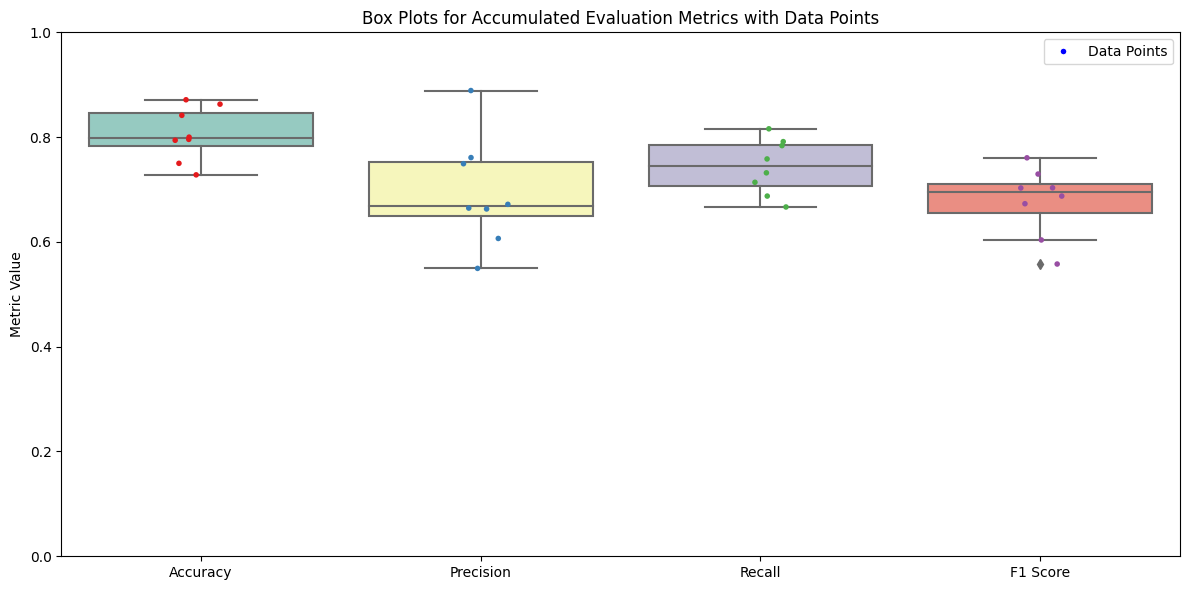


Experimentation completed!


In [73]:
# Define the topics as flexible terms (subwords or whole words)
topics = ["gas shows" , "oil show", "overpressure", "fluid communication" , "gas bearing", "stuck pipe" , "pressure build-up", "sand_production"]

# Approach-1 : Rule-based method filtering
df_predicted, df_predicted_neg = rbm_execute(df,"predicted",topics)



In [98]:
df = pd.read_excel("/content/sample_data/robust_test_dataset.xlsx")

  0%|          | 0/8 [00:00<?, ?it/s]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!



Calculating prediction metrics...


  0%|          | 0/8 [00:00<?, ?it/s]


Plotting results boxplot...


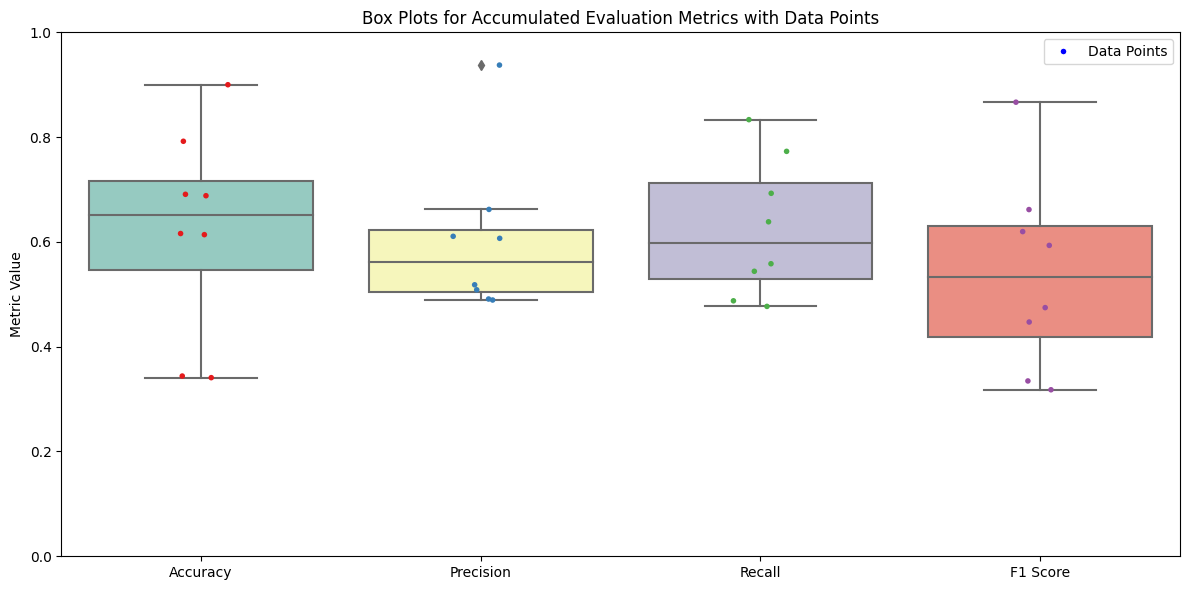


Experimentation completed!


In [106]:
# Approach-2 : spaCy NegEx package

concatenated_df = pd.DataFrame()

for topic in tqdm(topics):
  df2 = spacy_keyword_processing(topic,df)
  concatenated_df = pd.concat([concatenated_df, df2], ignore_index=True)

df_spacy = spacy_eval(concatenated_df)
df_predicted, df_predicted_neg = rbm_execute(df_spacy,'prediction_negex',topics)






In [8]:
# Assuming 'df' is your DataFrame
df_predicted.to_excel("dataset_predicted.xlsx", index=False)